# Import standard packages

In [1]:
import numpy as np
import cv2
import sys
import os
import json
import pickle
from scipy import misc

import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# Define face detection function

In [2]:
def detect(frame):
    height, width, depth = frame.shape

    # create grayscale version
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    # equalize histogram
    cv2.equalizeHist(grayscale, grayscale)

    # detect objects
    classifier = cv2.CascadeClassifier("Data/haarcascade_frontalface_alt.xml")
    DOWNSCALE = 4
    minisize = (frame.shape[1]/DOWNSCALE,frame.shape[0]/DOWNSCALE)
    miniframe = cv2.resize(frame, minisize)
    faces = classifier.detectMultiScale(miniframe)
    if len(faces)>0:
        # print 'face detected!'
        for i in faces:
            x, y, w, h = [ v*DOWNSCALE for v in i ]
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0))
    return frame, faces

# Set up caffe classifier

In [3]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
home_dir = os.getenv("HOME")
caffe_root = os.path.join(home_dir, 'caffe')  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, os.path.join(caffe_root, 'python'))

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [4]:
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !~/caffe/scripts/download_model_binary.py ~/caffe/models/bvlc_reference_caffenet

Model already exists.


In [5]:
caffe.set_mode_cpu()

model_def = os.path.join(caffe_root, 'models', 'bvlc_reference_caffenet','deploy.prototxt')
model_weights = os.path.join(caffe_root, 'models','bvlc_reference_caffenet','bvlc_reference_caffenet.caffemodel')

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(os.path.join(caffe_root, 'python','caffe','imagenet','ilsvrc_2012_mean.npy'))
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [7]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227


In [8]:
# load ImageNet labels
labels_file = os.path.join(caffe_root, 'data','ilsvrc12','synset_words.txt')
if not os.path.exists(labels_file):
    !~/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

# Define classifier function

In [9]:
def classify(image_filename):
    image = caffe.io.load_image(image_filename)
    transformed_image = transformer.preprocess('data', image)
    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = transformed_image

    ### perform classification
    output = net.forward()

    output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
    # sort top five predictions from softmax output
    top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

    return zip(output_prob[top_inds], labels[top_inds])   

# Test methods

In [10]:
img_dir = os.path.join('Data','Images')
images = os.listdir(img_dir)

cat_dog_men_Webmd
[[14 11 28 28]
 [85  9 33 33]]
[(0.28133565, 'n02088364 beagle'), (0.19036339, 'n02091032 Italian greyhound'), (0.056101825, 'n02089867 Walker hound, Walker foxhound'), (0.038784977, 'n02091134 whippet'), (0.036874022, 'n02113023 Pembroke, Pembroke Welsh corgi')]
Notting_Hill_Carnival_rubbish_Mirror
()
[(0.14249596, 'n03733131 maypole'), (0.071886808, 'n04200800 shoe shop, shoe-shop, shoe store'), (0.070214391, 'n09229709 bubble'), (0.067920066, 'n03447447 gondola'), (0.047388114, 'n02927161 butcher shop, meat market')]
Flag_of_Libya_1977_2011
()
[(0.084887654, 'n01930112 nematode, nematode worm, roundworm'), (0.065148994, 'n04592741 wing'), (0.034558326, 'n04266014 space shuttle'), (0.029746281, 'n04525038 velvet'), (0.028960546, 'n04286575 spotlight, spot')]
cat
()
[(0.31243625, 'n02123045 tabby, tabby cat'), (0.23797157, 'n02123159 tiger cat'), (0.12387245, 'n02124075 Egyptian cat'), (0.10075716, 'n02119022 red fox, Vulpes vulpes'), (0.070957333, 'n02127052 lynx, c

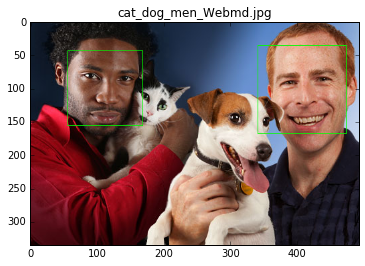

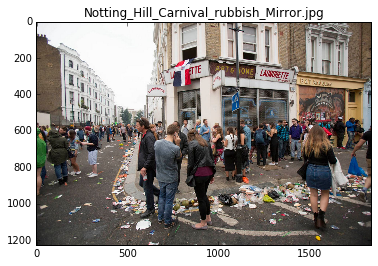

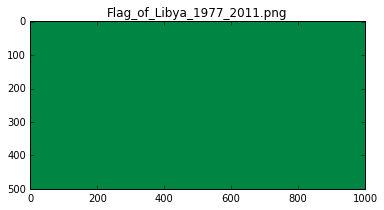

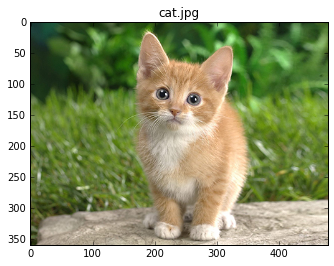

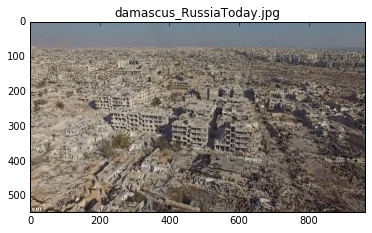

In [11]:
results = {}
for img_file in images:
    key = img_file.split(os.extsep)[0] # Nome do arquivo sem extensao
    print key
    img_full_path = os.path.join(img_dir,img_file)
    img = misc.imread(img_full_path)
    frame, faces = detect(img.copy())
    # Display the resulting frame
    plt.figure()
    plt.imshow(frame)
    plt.title(img_file)
    print faces             
    objects = classify(img_full_path)
    print objects
    results[key] = {
        'faces' : faces,
        'objects' : objects
    }
    


# Write results dictionary into a Pickle file

In [12]:
with open(os.path.join('Data','results.pkl'), 'w') as f:
    pickle.dump(results,f)

# Loading results from file

In [13]:
with open(os.path.join('Data','results.pkl'), 'r') as f:
    results = pickle.load(f)